# 11 - Prompt Engineering Text2Image

<br>
<br>

<img src="https://raw.githubusercontent.com/Hack-io-AI/ai_images/main/img_prompt.webp" style="width:400px;"/>

<h1>Tabla de Contenidos<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1---Pipeline-para-testeo" data-toc-modified-id="1---Pipeline-para-testeo-1">1 - Pipeline para testeo</a></span></li><li><span><a href="#2---Anatomía-de-un-buen-prompt" data-toc-modified-id="2---Anatomía-de-un-buen-prompt-2">2 - Anatomía de un buen prompt</a></span><ul class="toc-item"><li><span><a href="#2.1---Asunto" data-toc-modified-id="2.1---Asunto-2.1">2.1 - Asunto</a></span></li><li><span><a href="#2.2---Medio" data-toc-modified-id="2.2---Medio-2.2">2.2 - Medio</a></span></li><li><span><a href="#2.3---Estilo" data-toc-modified-id="2.3---Estilo-2.3">2.3 - Estilo</a></span></li><li><span><a href="#2.4---Webs-Art-sharing" data-toc-modified-id="2.4---Webs-Art-sharing-2.4">2.4 - Webs Art-sharing</a></span></li><li><span><a href="#2.5---Resolución" data-toc-modified-id="2.5---Resolución-2.5">2.5 - Resolución</a></span></li><li><span><a href="#2.6---Detalles-adicionales" data-toc-modified-id="2.6---Detalles-adicionales-2.6">2.6 - Detalles adicionales</a></span></li><li><span><a href="#2.7---Color" data-toc-modified-id="2.7---Color-2.7">2.7 - Color</a></span></li><li><span><a href="#2.8---Iluminación" data-toc-modified-id="2.8---Iluminación-2.8">2.8 - Iluminación</a></span></li></ul></li><li><span><a href="#3---Negative-prompt" data-toc-modified-id="3---Negative-prompt-3">3 - Negative prompt</a></span></li><li><span><a href="#4---Proceso-de-construir-un-buen-prompt" data-toc-modified-id="4---Proceso-de-construir-un-buen-prompt-4">4 - Proceso de construir un buen prompt</a></span><ul class="toc-item"><li><span><a href="#4.1---Construcción-iterativa-de-prompts" data-toc-modified-id="4.1---Construcción-iterativa-de-prompts-4.1">4.1 - Construcción iterativa de prompts</a></span></li><li><span><a href="#4.2---Usando-el-negative-prompt" data-toc-modified-id="4.2---Usando-el-negative-prompt-4.2">4.2 - Usando el negative prompt</a></span></li></ul></li><li><span><a href="#5---Técnicas-de-Prompting" data-toc-modified-id="5---Técnicas-de-Prompting-5">5 - Técnicas de Prompting</a></span><ul class="toc-item"><li><span><a href="#5.1---Pesos-de-las-palabras-clave" data-toc-modified-id="5.1---Pesos-de-las-palabras-clave-5.1">5.1 - Pesos de las palabras clave</a></span></li><li><span><a href="#5.2---Composición-de-palabras-clave" data-toc-modified-id="5.2---Composición-de-palabras-clave-5.2">5.2 - Composición de palabras clave</a></span></li><li><span><a href="#5.3---Uniendo-caras" data-toc-modified-id="5.3---Uniendo-caras-5.3">5.3 - Uniendo caras</a></span></li></ul></li><li><span><a href="#6---Longitud-del-prompt" data-toc-modified-id="6---Longitud-del-prompt-6">6 - Longitud del prompt</a></span></li></ul></div>

## 1 - Pipeline para testeo

Vamos a ver una guía sobre cómo realizar prompts de manera correcta para la generación de imágenes, pero antes vamos a construir una clase que inicia un pipeline para poder realizar testeos sobre los prompts que vayamos escribiendo. 

In [3]:
# para quitar warnings 

from transformers import logging
logging.set_verbosity_error()

import warnings
warnings.filterwarnings('ignore')

In [4]:
# importamos librerías

from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch
from dotenv import load_dotenv      
import os                           

In [5]:
# definimos la clase pipeline

class DifPipe:
    
    def __init__(self, 
                 modelo: str='dreamlike-art/dreamlike-photoreal-2.0',   # id del modelo
                 dispositivo: str='mps',                                # cpu, cuda, mps
                 pasos_inferencia: int=50,                              # pasos denoising
                 altura: int=512,                                       # altura imagen generada
                 ancho: int=512,                                        # ancho imagen generada
                 guia: float=8.5,                                       # ajuste a texto
                 jit: bool=True,                                        # compilación
                 safetensor: bool=True,                                 # tensores seguros
                 dtype: float=torch.float32                             # tipo de dato tensores
                ):
        
        
        # atributos
        self.modelo = modelo
        self.dispositivo = dispositivo
        self.pasos_inferencia = pasos_inferencia
        self.altura = altura
        self.ancho = ancho
        self.guia = guia
        self.jit = jit
        self.safetensor=safetensor
        self.dtype=dtype
        
        
        # importamos el token desde el archivo .env
        load_dotenv()
        HUGGINGFACE_TOKEN = os.getenv('HUGGING_FACE_TOKEN')
        
        
        
        # inicialización del atributo pipeline
        self.pipe = DiffusionPipeline.from_pretrained(pretrained_model_name_or_path=self.modelo,
                                                      use_safetensors=self.safetensor,
                                                      torch_dtype=self.dtype,            
                                                      token=HUGGINGFACE_TOKEN
                                                     ) 


        # selección del dispositivo
        self.pipe = self.pipe.to(device=self.dispositivo)


        # slicing de atención
        self.pipe.enable_attention_slicing()


        # scheduler
        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(config=self.pipe.scheduler.config)
        
        
        
    def generate(self, prompt: str, negative_prompt: str='ugly') -> object:
        
        # generamos una imagen desde el prompt 
        resultado = self.pipe(prompt=prompt,                                # texto de entrada desde el usuario
                              negative_prompt=negative_prompt,              # lo que no queremos
                              num_inference_steps=self.pasos_inferencia,    # nº de pasos para inferencia
                              height=self.altura,                           # altura en píxeles
                              width=self.ancho,                             # ancho en píxeles
                              guidance_scale=self.guia,                     # más ajustado al texto
                              jit=self.jit,                                 # compilación dinámica
                             )
        
        torch.mps.empty_cache()
        
        return resultado.images[0]

In [6]:
modelo = 'stabilityai/stable-diffusion-2-1' 

#modelo = 'CompVis/stable-diffusion-v1-4'  # 4Gb

#modelo = 'SG161222/Realistic_Vision_V6.0_B1_noVAE'  # 5.5Gb

#modelo = 'stablediffusionapi/realistic-stock-photo'  # 7Gb

modelo = 'stablediffusionapi/realistic-stock-photo-v2' # 7Gb  # este mola

#modelo = 'digiplay/insaneRealistic_v1' # parece que hace blending

In [7]:
# inicialización del objeto

p = DifPipe(modelo=modelo, safetensor=None)

text_encoder_2/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /Users/tecnico.IA/.cache/huggingface/hub/models--stablediffusionapi--realistic-stock-photo-v2/snapshots/7c76bc849746ba0a36c49776e5a7b77856e7ba9d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/tecnico.IA/.cache/huggingface/hub/models--stablediffusionapi--realistic-stock-photo-v2/snapshots/7c76bc849746ba0a36c49776e5a7b77856e7ba9d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /Users/tecnico.IA/.cache/huggingface/hub/models--stablediffusionapi--realistic-stock-photo-v2/snapshots/7c76bc849746ba0a36c49776e5a7b77856e7ba9d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/tecnico.IA/.cache/huggingface/hub/models--stablediffusionapi--realistic-stock-photo-v2/snapshots/7c76bc849746ba0a36c49776e5a7b77856e7ba9d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error

## 2 - Anatomía de un buen prompt

Veamos cómo construir un buen prompt. Un prompt necesita ser detallado y específico. El proceso general es revisar una lista de categorías de palabras clave y decidir si se desea usar alguna de ellas. Una lista básica pueden ser las siguientes, aunque por supuesto no es necesario utilizarlas todas.


1. **Asunto**
2. **Medio**
3. **Estilo**
4. **Webs Art-sharing** 
5. **Resolución**
6. **Detalles adicionales**
7. **Color**
8. **Iluminación**

### 2.1 - Asunto

El asunto es lo que queremos ver en la imagen. Un error muy común es no escribir lo suficiente al respecto de asunto que queremos representar. Digamos que queremos generar un mago lanzando magia. Un principiante podría escribir:

In [6]:
prompt = 'A wizard'

imagen = p.generate(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

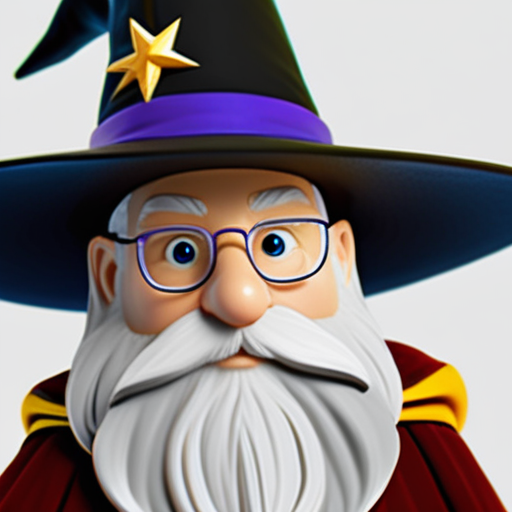

In [7]:
imagen

Este prompt deja demasiado espacio para la imaginación. Deberíamos de ser más descriptivos en nuestro prompt.
¿Cómo queremos que se vea el mago? ¿Tenemos alguna palabra clave para describirlo más específicamente? ¿Qué lleva puesto? ¿Qué tipo de magia está lanzando? ¿Está de pie, corriendo o flotando en el aire? ¿Cuál es la escena de fondo? Los modelos no pueden leer nuestras mentes. Tenemos que decir exactamente lo que queremos.

Por ejemplo, digamos que él es poderoso y misterioso y usa magia de relámpagos. Lleva una capa gris y vestimenta de cuero. Está de pie en una roca. Lleva un sombrero. El fondo es una fortaleza. De esta manera la imagen será más consistente.

In [8]:
prompt = '''a strong and powerful mysterious wizard, smile, standing on a rock, 
            lightning magic, hat, detailed leather clothing with gemstones, 
            grey coat, fortress background'''

imagen = p.generate(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

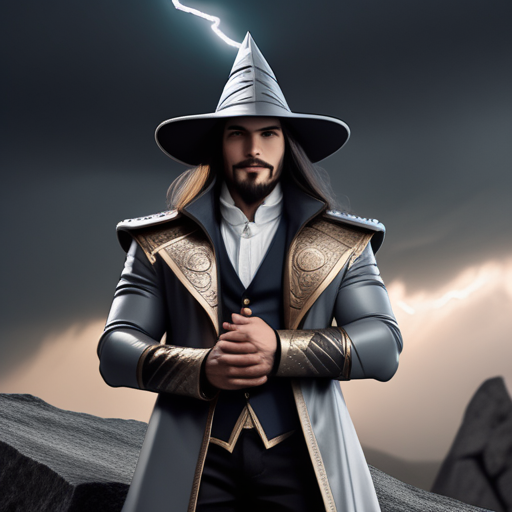

In [9]:
imagen

Es común ver el rostro distorsionado en este tipo de modelos. Veremos más adelante algunas formas de arreglar este tipo de detalles.

### 2.2 - Medio

El medio es el material utilizado para crear la obra de arte. Algunos ejemplos son ilustración, pintura al óleo, renderizado 3D y fotografía. El medio tiene un efecto fuerte porque una sola palabra clave puede cambiar drásticamente el estilo.

Añadamos la palabra clave arte digital.

In [10]:
prompt = '''a strong and powerful mysterious wizard, smile, standing on a rock, 
            lightning magic, hat, detailed leather clothing with gemstones, 
            grey coat, fortress background, 
            digital art'''

imagen = p.generate(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

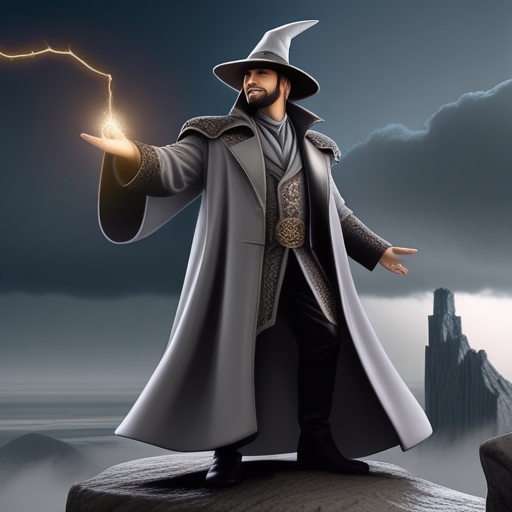

In [11]:
imagen

### 2.3 - Estilo

El estilo se refiere al estilo artístico de la imagen. Algunos ejemplos incluyen impresionista, surrealista o arte pop, etc.

Añadimos hiperrealista, fantasía, arte oscuro al prompt.

In [12]:
prompt = '''a strong and powerful mysterious wizard, smile, standing on a rock, 
            lightning magic, hat, detailed leather clothing with gemstones, 
            grey coat, fortress background, 
            digital art, 
            hyperrealistic, fantasy, dark art'''

imagen = p.generate(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

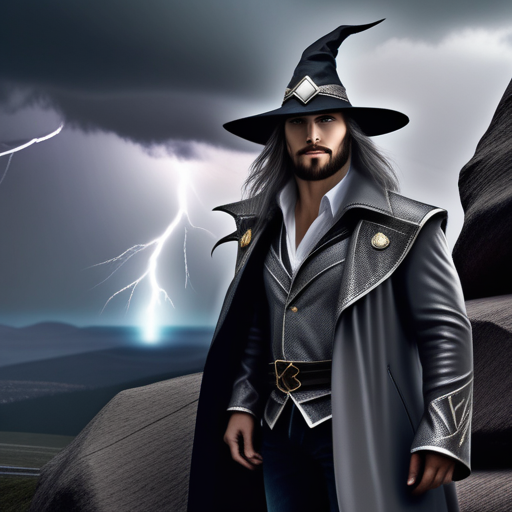

In [13]:
imagen

### 2.4 - Webs Art-sharing

Sitios web gráficos de nicho como Artstation y DeviantArt agregan muchas imágenes de distintos géneros. Usarlos en un prompt es una manera segura de orientar la imagen hacia estos estilos.

In [14]:
prompt = '''a strong and powerful mysterious wizard, smile, standing on a rock, 
            lightning magic, hat, detailed leather clothing with gemstones, 
            grey coat, fortress background, 
            digital art, 
            hyperrealistic, fantasy, dark art, 
            artstation'''

imagen = p.generate(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

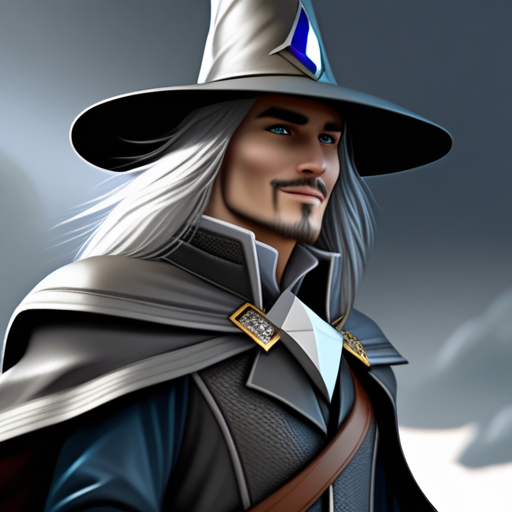

In [15]:
imagen

### 2.5 - Resolución

La resolución representa cuán nítida y detallada es la imagen. Añadamos las palabras clave altamente detallada y enfoque nítido.


In [16]:
prompt = '''a strong and powerful mysterious wizard, smile, standing on a rock, 
            lightning magic, hat, detailed leather clothing with gemstones, 
            grey coat, fortress background, 
            digital art, 
            hyperrealistic, fantasy, dark art, 
            artstation, 
            highly detailed, sharp focus'''

imagen = p.generate(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

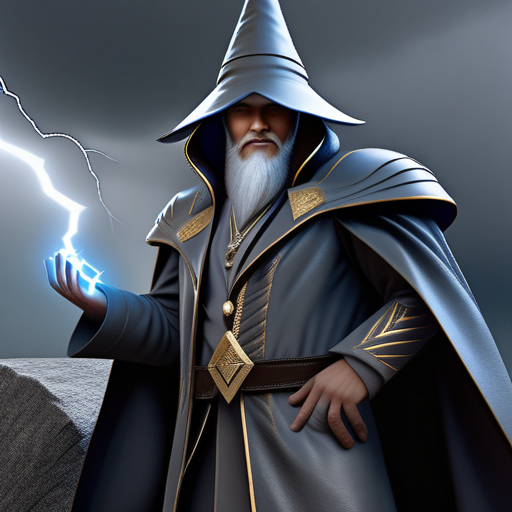

In [17]:
imagen

### 2.6 - Detalles adicionales

Los detalles adicionales son elementos que se añaden para modificar una imagen. Añadiremos ciencia ficción y distópico para darle un toque especial a la imagen.

In [18]:
prompt = '''a strong and powerful mysterious wizard, smile, standing on a rock, 
            lightning magic, hat, detailed leather clothing with gemstones, 
            grey coat, fortress background,  
            digital art, 
            hyperrealistic, fantasy, dark art, 
            artstation,
            highly detailed, sharp focus, 
            sci-fi, dystopian'''

imagen = p.generate(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

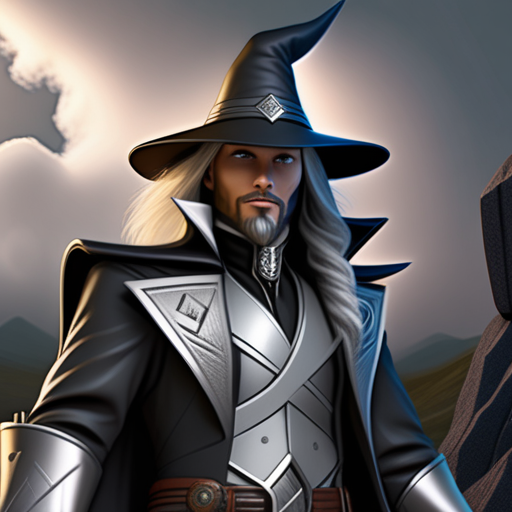

In [19]:
imagen

### 2.7 - Color

Podemos controlar el color general de la imagen añadiendo palabras clave de color. Los colores que especifiques pueden aparecer como un tono o en objetos. Añadamos algo de color dorado a la imagen con la palabra clave oro iridiscente.

In [20]:
prompt = '''a strong and powerful mysterious wizard, smile, standing on a rock, 
            lightning magic, hat, detailed leather clothing with gemstones, 
            grey coat, fortress background, 
            digital art, 
            hyperrealistic, fantasy, dark art, 
            artstation,
            highly detailed, sharp focus, 
            sci-fi, dystopian,
            iridescent gold'''

imagen = p.generate(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

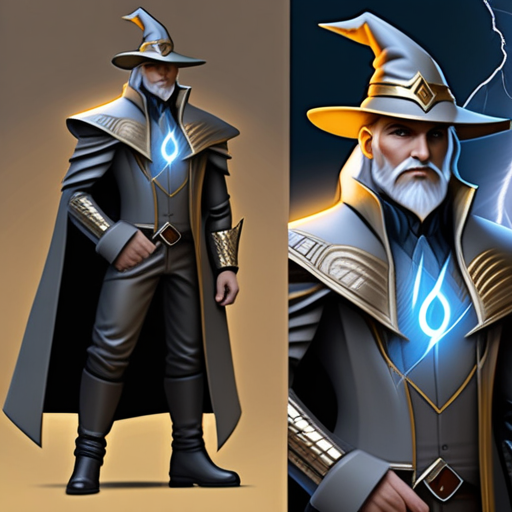

In [21]:
imagen

### 2.8 - Iluminación

Cualquier fotógrafo nos diría que la iluminación es clave para crear imágenes exitosas. Las palabras clave de iluminación pueden tener un gran efecto en la apariencia de la imagen. Añadamos iluminación de estudio para que parezca una foto de estudio.


In [22]:
prompt = '''a strong and powerful mysterious wizard, smile, standing on a rock, 
            lightning magic, hat, detailed leather clothing with gemstones, 
            grey coat, fortress background,  
            digital art, 
            hyperrealistic, fantasy, dark art, 
            artstation,
            highly detailed, sharp focus, 
            sci-fi, dystopian,
            iridescent gold,
            studio lighting'''

imagen = p.generate(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

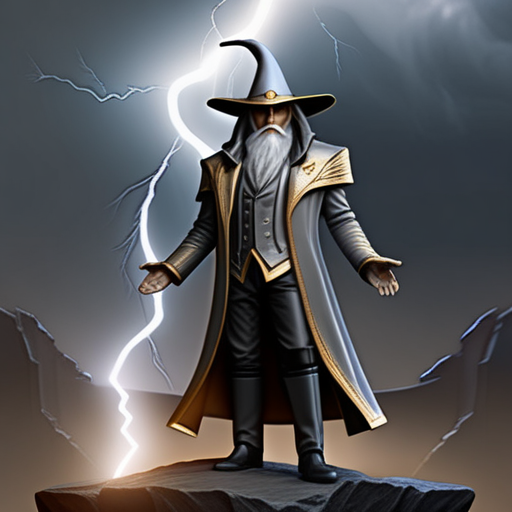

In [23]:
imagen

## 3 - Negative prompt

Usar prompts negativos es otra excelente manera de orientar la imagen, pero en lugar de poner lo que queremos, ponemos lo que no queremos. No necesitan ser objetos. También pueden ser estilos y atributos no deseados, por ejemplo, feo, deformado. También es una manera de proteger la salida del modelo, por ejemplo desnudos o cosas ofensivas.

In [9]:
neg_prompt = '''painting, 
                extra fingers, 
                mutated hands, 
                poorly drawn hands, 
                poorly drawn face, 
                deformed, 
                disfigured,
                ugly, 
                blurry, 
                bad anatomy, 
                bad proportions, 
                extra limbs, 
                cloned face, 
                skinny, 
                glitchy, 
                double torso, 
                extra arms, 
                extra hands, 
                mangled fingers, 
                missing lips, 
                ugly face, 
                distorted face, 
                extra legs, 
                anime,
                naked'''


imagen = p.generate(prompt, neg_prompt)

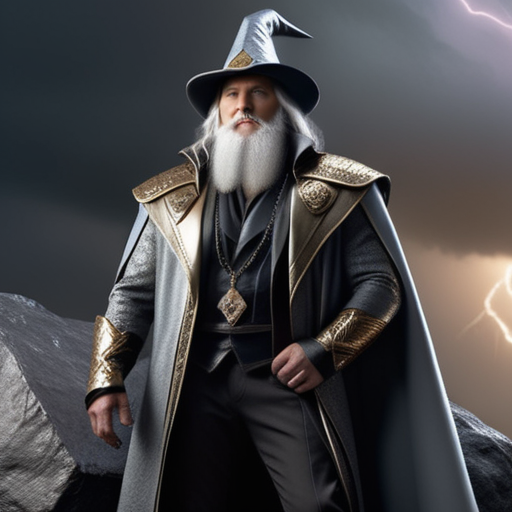

In [25]:
imagen

## 4 - Proceso de construir un buen prompt

### 4.1 - Construcción iterativa de prompts

Debemos abordar la construcción de prompts como un proceso iterativo. Como muestra la sección anterior, las imágenes pueden ser bastante buenas con solo unas pocas palabras clave añadidas al tema. Siempre se debería comenzar con un prompt simple que incluya solo el tema, el medio y el estilo. Generamos al menos 4 imágenes a la vez para ver qué se obtiene. La mayoría de los prompts no funcionan el 100% del tiempo, sin embargo queremos tener una idea de lo que pueden hacer estadísticamente.

Añadimos como máximo dos palabras clave a la vez y otra vez, generamos al menos 4 imágenes para evaluar su efecto.

### 4.2 - Usando el negative prompt

Añadir palabras clave al prompt negativo puede ser parte del proceso iterativo. Las palabras clave pueden ser objetos o partes del cuerpo que quieras evitar. Por ejemplo, hay modelos que no son muy buenos renderizando manos, no es mala idea usar "mano" en el prompt negativo para ocultarlas. Igual que hay modelos que no tienen ningún tipo de filtro de seguridad, por lo que añadir ciertas palabras claves al prompt negativo es buena idea para proteger la salida.

## 5 - Técnicas de Prompting

### 5.1 - Pesos de las palabras clave

Para algunos modelos podemos ajustar el peso de una palabra clave usando la sintaxis (palabra clave: factor). El factor es un valor tal que, si es menor que 1, significa menos importancia, y si es mayor que 1, significa más importancia. Existen sintaxis equivalentes de ajustar la fuerza de una palabra clave es usar () y []. (palabra clave) aumenta la fuerza de la palabra clave por un factor de 1.1 y es lo mismo que (palabra clave: 1.1). [palabra clave] disminuye la fuerza por un factor de 0.9 y es lo mismo que (palabra clave: 0.9).


+ (palabra clave) es equivalente a (palabra clave: 1.1)
+ ((palabra clave)) es equivalente a (palabra clave: 1.21)
+ (((palabra clave))) es equivalente a (palabra clave: 1.33)

De manera similar, los efectos de usar múltiples [] son:

+ [palabra clave] es equivalente a (palabra clave: 0.9)
+ [[palabra clave]] es equivalente a (palabra clave: 0.81)
+ [[[palabra clave]]] es equivalente a (palabra clave: 0.73)

In [159]:
prompt = '''dog, autumn in paris, ornate, beautiful, 
            atmosphere, vibe, mist, smoke, fire, chimney, 
            rain, wet, pristine, puddles, melting, dripping, 
            by stanley artgerm lau, greg rutkowski, 
            thomas kindkade, alphonse mucha, loish, norman rockwell'''

imagen = p.generate(prompt, neg_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

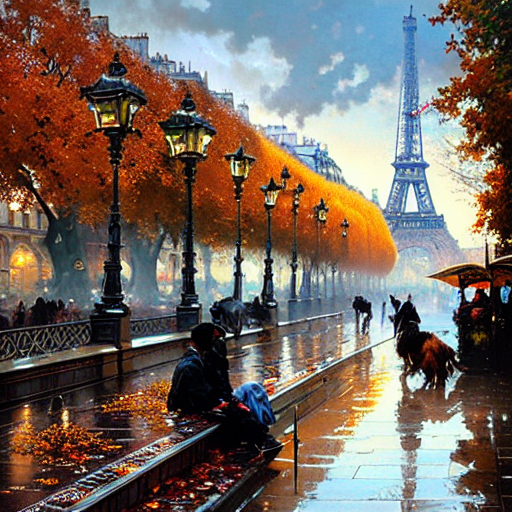

In [160]:
imagen

In [161]:
prompt = '''(dog: 1.5), autumn in paris, ornate, beautiful, 
            atmosphere, vibe, mist, smoke, fire, chimney, 
            rain, wet, pristine, puddles, melting, dripping, 
            by stanley artgerm lau, greg rutkowski, 
            thomas kindkade, alphonse mucha, loish, norman rockwell'''

imagen = p.generate(prompt, neg_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

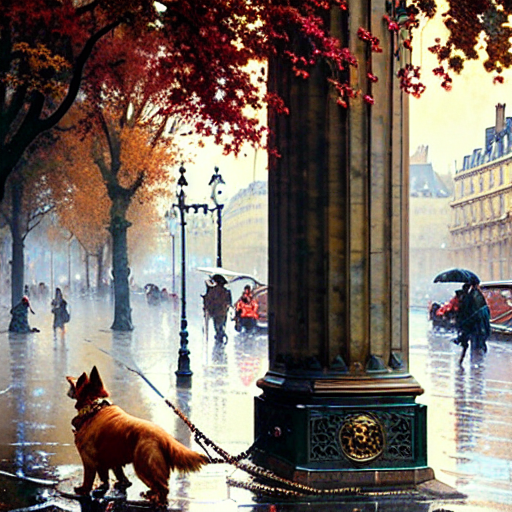

In [162]:
imagen

### 5.2 - Composición de palabras clave

Puedes combinar dos palabras clave. El término adecuado es programación de prompt. La sintaxis es [palabraclave1:palabraclave2:factor]. El factor controla en qué paso se cambia de la palabra clave 1 a la palabra clave 2, es un número entre 0 y 1.

In [10]:
prompt = 'Oil painting portrait of [Joe Biden: Donald Trump: 0.5]'

imagen = p.generate(prompt, neg_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

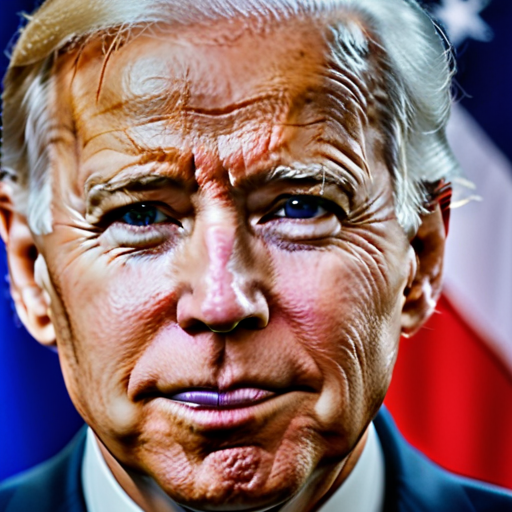

In [11]:
imagen

### 5.3 - Uniendo caras

Un caso de uso común es crear un nuevo rostro con una apariencia particular, tomando prestadas características de actores y actrices. Esto nos permite también generar consistencia a la hora de generar caras.

In [24]:
prompt = '''(Ana de Armas:0.2), (Emma Watson:0.5), (Margot Robbie:0.9), 
            photo of young woman, highlight hair, sitting outside restaurant, 
            wearing dress, studio lighting, looking at the camera, dslr, 
            ultra quality, sharp focus, Fujifilm XT3, crystal clear, 8K UHD'''


imagen = p.generate(prompt, neg_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

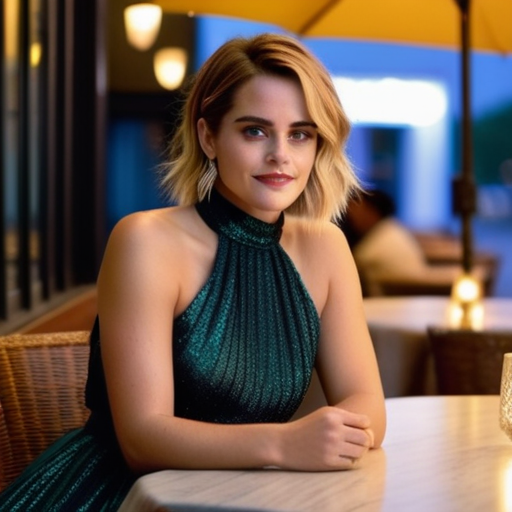

In [25]:
imagen

## 6 - Longitud del prompt

Dependiendo del modelo que estemos utilizando, podría haber un número máximo de palabras clave que podemos usar en el prompt. En el modelo básico de Stable Diffusion v1, ese límite es de 75 tokens.

El modelo CLIP de Stable Diffusion convierte automáticamente el prompt en tokens, una representación numérica de las palabras que conoce. Si introduces una palabra que no ha visto antes, se dividirá en 2 o más sub-palabras hasta que sepa lo que es. Las palabras que conoce se llaman tokens, los cuales están representados como números.

Por ejemplo, "dream" es un token y "beach" es otro token. Pero "dreambeach" son dos tokens porque el modelo no conoce esta palabra, y por eso el modelo divide la palabra en "dream" y "beach" que sí conoce.

¿Qué pasa si queremos iniciar un nuevo prompt antes de alcanzar los 75 tokens? A veces querremos hacer eso porque el token al comienzo de un bloque puede ser más efectivo, y puede que deseemos agrupar palabras clave relacionadas en un bloque. Podemos usar la palabra clave BREAK para iniciar un bloque. El siguiente prompt utiliza dos bloques para especificar que el sombrero es blanco y el vestido es azul.

In [28]:
prompt= '''photo of a woman in white hat
           BREAK
           blue dress'''

imagen = p.generate(prompt, neg_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

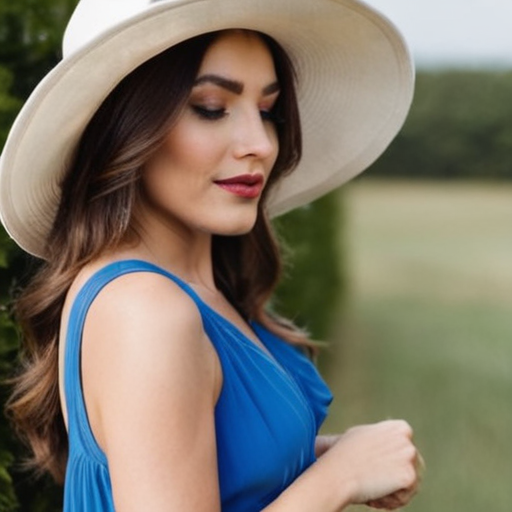

In [29]:
imagen